## Calculate Bias Metrics Pre-Training 
haimtran June 09 2023

- Hand calculate bias metrics: CI, DPL, KL, JS
- Compare with Wrangler Bias Report
- [Amazon Fairness and Bias in ML Paper](https://pages.awscloud.com/rs/112-TZM-766/images/Fairness.Measures.for.Machine.Learning.in.Finance.pdf)
- [Amazon SM Clarify Source Code](https://github.com/aws/amazon-sagemaker-clarify/blob/master/src/smclarify/bias/metrics/pretraining.py) 

In [76]:
import os

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker
from IPython.display import Markdown, display

In [77]:
import decimal
from decimal import Decimal

In [78]:
decimal.setcontext(decimal.Context(prec=16))

## SageMaker Session

In [79]:
role = sagemaker.get_execution_role()

In [80]:
session = sagemaker.session.Session()

In [81]:
bucket = session.default_bucket()

In [82]:
region = session.boto_region_name

## Parameters for Bias Analysis 

In [83]:
feature_name = "marital"
facet = "married"
target_name = "y"
label = "yes"

## Upload Bank Data to S3 for Wrangler 

In [84]:
local_file_path = "./../../data/bank-additional/bank-additional-full.csv"

In [85]:
s3_client = boto3.client("s3")

In [86]:
s3_client.upload_file(
    local_file_path,
    bucket,
    "bank/bank-additional-full.csv",
)

## Download Adult DataSet from S3 

In [87]:
from sagemaker.s3 import S3Downloader

adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            f"sagemaker-example-files-prod-{region}",
            "datasets/tabular/uci_adult/adult.data",
        ),
        local_path="./",
        sagemaker_session=session,
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            f"sagemaker-example-files-prod-{region}",
            "datasets/tabular/uci_adult/adult.test",
        ),
        local_path="./",
        sagemaker_session=session,
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data already on disk.
adult.test already on disk.


## Parameters for Bias Analysis 

In [88]:
data_path = "./adult.data"

In [89]:
feature_name = "Sex"
facet = 0
target_name = "Target"
label = 1

## Load Data 

In [90]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test",
    names=adult_columns,
    sep=r"\s*,\s*",
    engine="python",
    na_values="?",
    skiprows=1,
).dropna()

training_data.head()
df = training_data

This is the uci dataset 
- predict income greater or less than 50K
- let consider bias in Sex column/feature, facets are male and femal

In [91]:
df_origin = df.copy()

In [92]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [93]:
# df.value_counts(['Sex']).plot.bar()
# plt.show()

In [94]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(
                result[column].fillna("None")
            )
    return result, encoders


training_data = pd.concat(
    [training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1
)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


This is the uci dataset 
- Target 0: income <=50K, 1: income>50K
- Calculate bias in Sex column, facets are male: 1, female: 0

In [95]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [96]:
df = training_data

In [97]:
# df.dtypes

## Sex Comlumn - Feature 

In [98]:
count_facet = df.value_counts(feature_name)

In [99]:
count_facet

Sex
1    20380
0     9782
dtype: int64

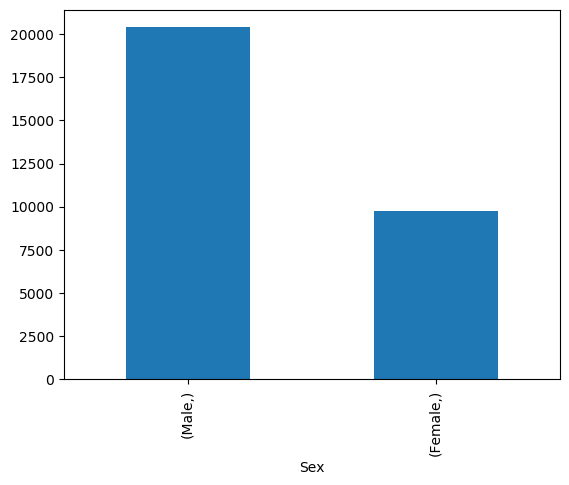

In [100]:
df_origin.value_counts([feature_name]).plot.bar(x=['Male','Female'])
plt.show()

## Class Imbalance - CI

Here is the [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-bias-metric-class-imbalance.html)

## $$ CI = \frac{n_a - n_d}{n_a + n_d}$$

- $n_a$ is the number of facet a ==> no. of male 
- $n_d$ is the number of facet d ==> no. of female 

In [101]:
n_d = len(df[df['Sex']==0])
print(f'no. female: {n_d}')

no. female: 9782


In [102]:
n_a = len(df[df['Sex']==1])
print(f'no. male: {n_a}')

no. male: 20380


In [103]:
ci = (n_a - n_d) / (n_a + n_d)

In [104]:
print(f'class imbalanced ci: {ci:.16f}')

class imbalanced ci: 0.3513692725946555


In [105]:
def compute_ci(df, feature_name: str, facet_d: str):
    """
    I calcluate CI
    """
    # number of facet a
    n_d = len(df[df[feature_name] == facet_d])
    # number of facet d
    n_a = len(df[df[feature_name] != facet_d])
    # calculate ci
    ci = (n_a - n_d) / (n_a + n_d)
    return ci

In [106]:
ci = compute_ci(df, feature_name=feature_name, facet_d=facet)

In [107]:
display(Markdown(f"### class imbalanced facet married: {ci:.16f}"))

### class imbalanced facet married: 0.3513692725946555

## Difference in Positive Proportions in Labels (DPL)

## $$ q_a = \frac{n_a^{(1)}}{n_a}, q_d = \frac{n_d^{(1)}}{n_d} $$
## $$ DPL = (q_a - q_d) $$

- $n_d^{(1)}$ is the number of facet d given positive label ==> no. female and y = 1
- $n_a^{(1)}$ is the number of facet a given positive label ==> no. male and y = 1


In [108]:
# count female
n_d = len(df[df['Sex'] == 0])
print(f'no. female: {n_d}')

no. female: 9782


In [109]:
# count female given income >50K
n_d_1 = len(df[ (df['Sex'] == 0) & (df['Target'] == 1) ])
print(f'given label 1 (>50K) no. female: {n_d_1}')

given label 1 (>50K) no. female: 1112


In [110]:
# count male
n_a = len(df[df['Sex'] == 1])
print(f'no. male: {n_a}')

no. male: 20380


In [111]:
# count male give income >50K
n_a_1 = len(df[ (df['Sex'] == 1) & (df['Target'] == 1) ])
print(f'given label 1 (>50K) no. male: {n_a_1}')

given label 1 (>50K) no. male: 6396


In [112]:
q_d = n_d_1/n_d
print(f'ratio female >50K: {q_d}')

ratio female >50K: 0.11367818442036394


In [113]:
q_a = n_a_1/n_a
print(f'ratio male >50K: {q_a}')

ratio male >50K: 0.3138370951913641


In [114]:
# different in positive label
dpl = (n_a_1/n_a) - (n_d_1/n_d)

In [115]:
print(f'dpl: {dpl:.16f}')

dpl: 0.2001589107710002


In [116]:
def compute_dpl(
    df: pd.DataFrame, feature_name: str, facet_d: str, target_name: str, label
):
    """
    I calculate difference in positive proportions in labels
    """
    # number of facet a
    n_d = len(df[df[feature_name] == facet_d])
    # number of facet a given positive labels
    n_d_1 = len(df[(df[feature_name] == facet_d) & (df[target_name] == label)])
    # number of facet d
    n_a = len(df[df[feature_name] != facet_d])
    # number of facet d give positive labels
    n_a_1 = len(df[(df[feature_name] != facet_d) & (df[target_name] == label)])
    # qa
    q_a = n_a_1 / n_a
    # qd
    q_d = n_d_1 / n_d
    # dpl
    dpl = q_a - q_d
    return dpl

In [117]:
dpl = compute_dpl(
    df=df,
    feature_name=feature_name,
    facet_d=facet,
    target_name=target_name,
    label=label,
)

In [118]:
dpl

0.20015891077100018

In [119]:
display(Markdown(f"### Difference in Positive Proportions in Labels: {dpl:.16f}"))

### Difference in Positive Proportions in Labels: 0.2001589107710002

## Kullback-Leibler Divergence (KL)

## $$ KL = \sum_y P_a(y)log{\frac{P_a(y)}{P_d(y)}}$$

In [120]:
# given income > 50K, how many female
p_positive_given_d = len(df[(df["Sex"] == 0) & (df["Target"] == 1)]) / n_d
print(f'ratio female > 50K: {p_positive_given_d}')

ratio female > 50K: 0.11367818442036394


In [121]:
#give income > 50K, how many male
p_positive_given_a = len(df[(df["Sex"] == 1) & (df["Target"] == 1)]) / n_a
print(f'ratio male > 50K: {p_positive_given_a}')

ratio male > 50K: 0.3138370951913641


In [122]:
# given income <= 50K, how many female
p_negative_given_d = len(df[(df["Sex"] == 0) & (df["Target"] == 0)]) / n_d
print(f'ratio female <= 50K: {p_negative_given_d}')

ratio female <= 50K: 0.8863218155796361


In [123]:
#give income > 50K, how many male
p_negative_given_a = len(df[(df["Sex"] == 1) & (df["Target"] == 0)]) / n_a
print(f'ratio male <= 50K: {p_negative_given_a}')

ratio male <= 50K: 0.686162904808636


In [124]:
kl = p_positive_given_a * np.log(p_positive_given_a/p_positive_given_d) + p_negative_given_a*np.log(p_negative_given_a/p_negative_given_d)

In [125]:
print(f'kl: {kl:.16f}')

kl: 0.1430686515630643


In [126]:
def compute_kl(
    df: pd.DataFrame,
    feature_name: str,
    facet: str,
    target_name: str,
    label,
):
    """
    I compute Kullback-Leibler Divergence
    """
    # number of facet d - female 
    n_d = len(df[df[feature_name] == facet])
    # number of facet a - male 
    n_a = len(df[df[feature_name] != facet])
    # positive given d count facet d - female 
    p_positive_given_d = (
        len(df[(df[feature_name] == facet) & (df[target_name] == label)]) / n_d
    )
    # positive given a count facet a - male 
    p_positive_given_a = (
        len(df[(df[feature_name] != facet) & (df[target_name] == label)]) / n_a
    )
    # negative given d count facet d - female 
    p_negative_given_d = (
        len(df[(df[feature_name] == facet) & (df[target_name] != label)]) / n_d
    )
    # negative given a count facet a - male 
    p_negative_given_a = (
        len(df[(df[feature_name] != facet) & (df[target_name] != label)]) / n_a
    )
    # kl
    kl = p_positive_given_a * np.log(
        p_positive_given_a / p_positive_given_d
    ) + p_negative_given_a * np.log(p_negative_given_a / p_negative_given_d)
    return kl

In [127]:
kl = compute_kl(
    df=df,
    feature_name=feature_name,
    facet=0,
    target_name=target_name,
    label=1
)

In [128]:
kl

0.14306865156306434

In [129]:
display(Markdown(f"### KL Divergence: {kl:.16f}"))

### KL Divergence: 0.1430686515630643

## Jessen Shannon

## $$ JS = \frac{1}{2}[LK(P_a || P) + KL(P_d || P)]  $$

## $$ P = \frac{1}{2}(P_a + P_d)$$

In [130]:
# average over positive >50K
p_positive = 0.5*(p_positive_given_a + p_positive_given_d)

In [131]:
# average over negative <=50K
p_negative = 0.5*(p_negative_given_a + p_negative_given_d)

In [132]:
item_1 = p_positive_given_a*np.log(p_positive_given_a/p_positive) + p_negative_given_a*np.log(p_negative_given_a/p_negative)

In [133]:
item_2 = p_positive_given_d*np.log(p_positive_given_d/p_positive) + p_negative_given_d*np.log(p_negative_given_d/p_negative)

In [134]:
js = 0.5*(item_1 + item_2)

In [135]:
print(f'js: {js:.16f}')

js: 0.0307561446597730


In [136]:
def compute_js(
    df: pd.DataFrame, feature_name: str, facet: str, target_name: str, label
):
    """
    I compute Jessen Shannon Divergence
    """
    # number of facet d
    n_d = len(df[df[feature_name] == facet])
    # number of facet a
    n_a = len(df[df[feature_name] != facet])
    # positve given d
    p_positive_given_d = (
        len(df[(df[feature_name] == facet) & (df[target_name] == label)]) / n_d
    )
    # postive given a
    p_positive_given_a = (
        len(df[(df[feature_name] != facet) & (df[target_name] == label)]) / n_a
    )
    # negative given d
    p_negative_given_d = (
        len(df[(df[feature_name] == facet) & (df[target_name] != label)]) / n_d
    )
    # negative given a
    p_negative_given_a = (
        len(df[(df[feature_name] != facet) & (df[target_name] != label)]) / n_a
    )
    # average positive
    p_positive = 0.5 * (p_positive_given_a + p_positive_given_d)
    # average negative
    p_negative = 0.5 * (p_negative_given_a + p_negative_given_d)
    # term 1
    item_1 = p_positive_given_a * np.log(
        p_positive_given_a / p_positive
    ) + p_negative_given_a * np.log(p_negative_given_a / p_negative)
    # term 2
    item_2 = p_positive_given_d * np.log(
        p_positive_given_d / p_positive
    ) + p_negative_given_d * np.log(p_negative_given_d / p_negative)
    # jessen shannon
    js = 0.5 * (item_1 + item_2)
    return js

In [137]:
js = compute_js(
    df=df, feature_name=feature_name, facet=facet, target_name=target_name, label=label
)

In [138]:
js

0.030756144659773006

In [139]:
display(Markdown(f"### Jessen Shannon Divergence: {js:.16f}"))

### Jessen Shannon Divergence: 0.0307561446597730

## My Bias Report 

In [140]:
import json

In [141]:
bias_report = {
    "metrics": [
        {"name": "ci", "value": f"{ci:.16f}"},
        {"name": "dpl", "value": f"{dpl:.16f}"},
        {"name": "js", "value": f"{js:.16f}"},
        {"name": "kl", "value": f"{kl:.16f}"},
    ]
}

In [142]:
print(json.dumps(bias_report, indent=4))

{
    "metrics": [
        {
            "name": "ci",
            "value": "0.3513692725946555"
        },
        {
            "name": "dpl",
            "value": "0.2001589107710002"
        },
        {
            "name": "js",
            "value": "0.0307561446597730"
        },
        {
            "name": "kl",
            "value": "0.1430686515630643"
        }
    ]
}


## Read the Clarify Bias Report Here to Compare 

In [151]:
with open("./clarify-report/analysis.json","r") as file:
    sm_clarify_report = json.load(file)

In [154]:
# print(json.dumps(sm_clarify_report, indent=4))

In [165]:
sm_clarify_bias = sm_clarify_report['pre_training_bias_metrics']['facets']['Sex'][0]['metrics']

In [166]:
sm_clarify_bias

[{'name': 'CDDL',
  'description': 'Conditional Demographic Disparity in Labels (CDDL)',
  'value': 0.214915908649356},
 {'name': 'CI',
  'description': 'Class Imbalance (CI)',
  'value': 0.3513692725946555},
 {'name': 'DPL',
  'description': 'Difference in Positive Proportions in Labels (DPL)',
  'value': 0.20015891077100018},
 {'name': 'JS',
  'description': 'Jensen-Shannon Divergence (JS)',
  'value': 0.03075614465977302},
 {'name': 'KL',
  'description': 'Kullback-Liebler Divergence (KL)',
  'value': 0.14306865156306428},
 {'name': 'KS',
  'description': 'Kolmogorov-Smirnov Distance (KS)',
  'value': 0.20015891077100018},
 {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.2830674462421746},
 {'name': 'TVD',
  'description': 'Total Variation Distance (TVD)',
  'value': 0.20015891077100015}]

## Compare My Bias with SageMaker Clarify 

[IEEE 754 Double Precision](https://en.wikipedia.org/wiki/Double-precision_floating-point_format)

In [168]:
print("my ci {0:.16f} and clarify ci {1:.16f}".format(ci, sm_clarify_bias[1]["value"]))
print("my dpl {0:.16f} and clarify dpl {1:.16f}".format(dpl, sm_clarify_bias[2]["value"]))
print("my js {0:.16f} and clarify js {1:.16f}".format(js, sm_clarify_bias[3]["value"]))
print("my kl {0:.16f} and clarify kl {1:.16f}".format(kl, sm_clarify_bias[4]["value"]))

my ci 0.3513692725946555 and clarify ci 0.3513692725946555
my dpl 0.2001589107710002 and clarify dpl 0.2001589107710002
my js 0.0307561446597730 and clarify js 0.0307561446597730
my kl 0.1430686515630643 and clarify kl 0.1430686515630643
